## Import data and libraries

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Dropout, BatchNormalization, LSTM, Activation
from tensorflow.keras.activations import swish
from tensorflow.keras.utils import plot_model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.initializers import HeNormal
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings("ignore")

In [2]:
df_master = pd.read_csv("../data/Train.csv")
df = df_master.copy()
df.head()

,user_id,REGION,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,MRG,REGULARITY,TOP_PACK,FREQ_TOP_PACK,CHURN
0,00000bfd7d50f01092811bc0c8d7b0d6fe7c3596,FATICK,K > 24 month,4250.0,15.0,4251.0,1417.0,17.0,4.0,388.0,46.0,1.0,1.0,2.0,NO,54,On net 200F=Unlimited _call24H,8.0,0
1,00000cb4a5d760de88fecb38e2f71b7bec52e834,NaN,I 18-21 month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO,4,NaN,NaN,1
2,00001654a9d9f96303d9969d0a4a851714a4bb57,NaN,K > 24 month,3600.0,2.0,1020.0,340.0,2.0,NaN,90.0,46.0,7.0,NaN,NaN,NO,17,On-net 1000F=10MilF;10d,1.0,0
3,00001dd6fa45f7ba044bd5d84937be464ce78ac2,DAKAR,K > 24 month,13500.0,15.0,13502.0,4501.0,18.0,43804.0,41.0,102.0,2.0,NaN,NaN,NO,62,"Data:1000F=5GB,7d",11.0,0
4,000028d9e13a595abe061f9b58f3d76ab907850f,DAKAR,K > 24 month,1000.0,1.0,985.0,328.0,1.0,NaN,39.0,24.0,NaN,NaN,NaN,NO,11,Mixt 250F=Unlimited_call24H,2.0,0


In [3]:
df.shape

(2154048, 19)

## EDA

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2154048 entries, 0 to 2154047
Data columns (total 19 columns):
 #   Column          Dtype  
---  ------          -----  
 0   user_id         object 
 1   REGION          object 
 2   TENURE          object 
 3   MONTANT         float64
 4   FREQUENCE_RECH  float64
 5   REVENUE         float64
 6   ARPU_SEGMENT    float64
 7   FREQUENCE       float64
 8   DATA_VOLUME     float64
 9   ON_NET          float64
 10  ORANGE          float64
 11  TIGO            float64
 12  ZONE1           float64
 13  ZONE2           float64
 14  MRG             object 
 15  REGULARITY      int64  
 16  TOP_PACK        object 
 17  FREQ_TOP_PACK   float64
 18  CHURN           int64  
dtypes: float64(12), int64(2), object(5)
memory usage: 312.2+ MB


In [5]:
round(df.isna().sum().sort_values(ascending=False) / len(df), 4) * 100

ZONE2             93.65
ZONE1             92.12
TIGO              59.89
DATA_VOLUME       49.23
FREQ_TOP_PACK     41.90
TOP_PACK          41.90
ORANGE            41.56
REGION            39.43
ON_NET            36.52
MONTANT           35.13
FREQUENCE_RECH    35.13
REVENUE           33.71
ARPU_SEGMENT      33.71
FREQUENCE         33.71
REGULARITY         0.00
user_id            0.00
MRG                0.00
TENURE             0.00
CHURN              0.00
dtype: float64

In [6]:
df.TOP_PACK.unique()

array(['On net 200F=Unlimited _call24H', nan, 'On-net 1000F=10MilF;10d',
       'Data:1000F=5GB,7d', 'Mixt 250F=Unlimited_call24H',
       'MIXT:500F= 2500F on net _2500F off net;2d',
       'All-net 500F=2000F;5d', 'On-net 500F_FNF;3d',
       'Data: 100 F=40MB,24H', 'MIXT: 200mnoff net _unl on net _5Go;30d',
       'Jokko_Daily', 'Data: 200 F=100MB,24H', 'Data:490F=1GB,7d',
       'Twter_U2opia_Daily', 'On-net 500=4000,10d', 'Data:1000F=2GB,30d',
       'IVR Echat_Daily_50F', 'Pilot_Youth4_490',
       'All-net 500F =2000F_AllNet_Unlimited', 'Twter_U2opia_Weekly',
       'Data:200F=Unlimited,24H', 'On-net 200F=60mn;1d',
       'All-net 600F= 3000F ;5d', 'Pilot_Youth1_290',
       'All-net 1000F=(3000F On+3000F Off);5d', 'VAS(IVR_Radio_Daily)',
       'Data:3000F=10GB,30d', 'All-net 1000=5000;5d',
       'Twter_U2opia_Monthly', 'MIXT: 390F=04HOn-net_400SMS_400 Mo;4h\t',
       'FNF2 ( JAPPANTE)', 'Yewouleen_PKG', 'Data:150F=SPPackage1,24H',
       'WIFI_Family_2MBPS', 'Data:500F=2GB,2

In [7]:
df.REGION.unique() 

array(['FATICK', nan, 'DAKAR', 'LOUGA', 'TAMBACOUNDA', 'KAOLACK', 'THIES',
       'SAINT-LOUIS', 'KOLDA', 'KAFFRINE', 'DIOURBEL', 'ZIGUINCHOR',
       'MATAM', 'SEDHIOU', 'KEDOUGOU'], dtype=object)

In [8]:
df.MRG.unique()

array(['NO'], dtype=object)

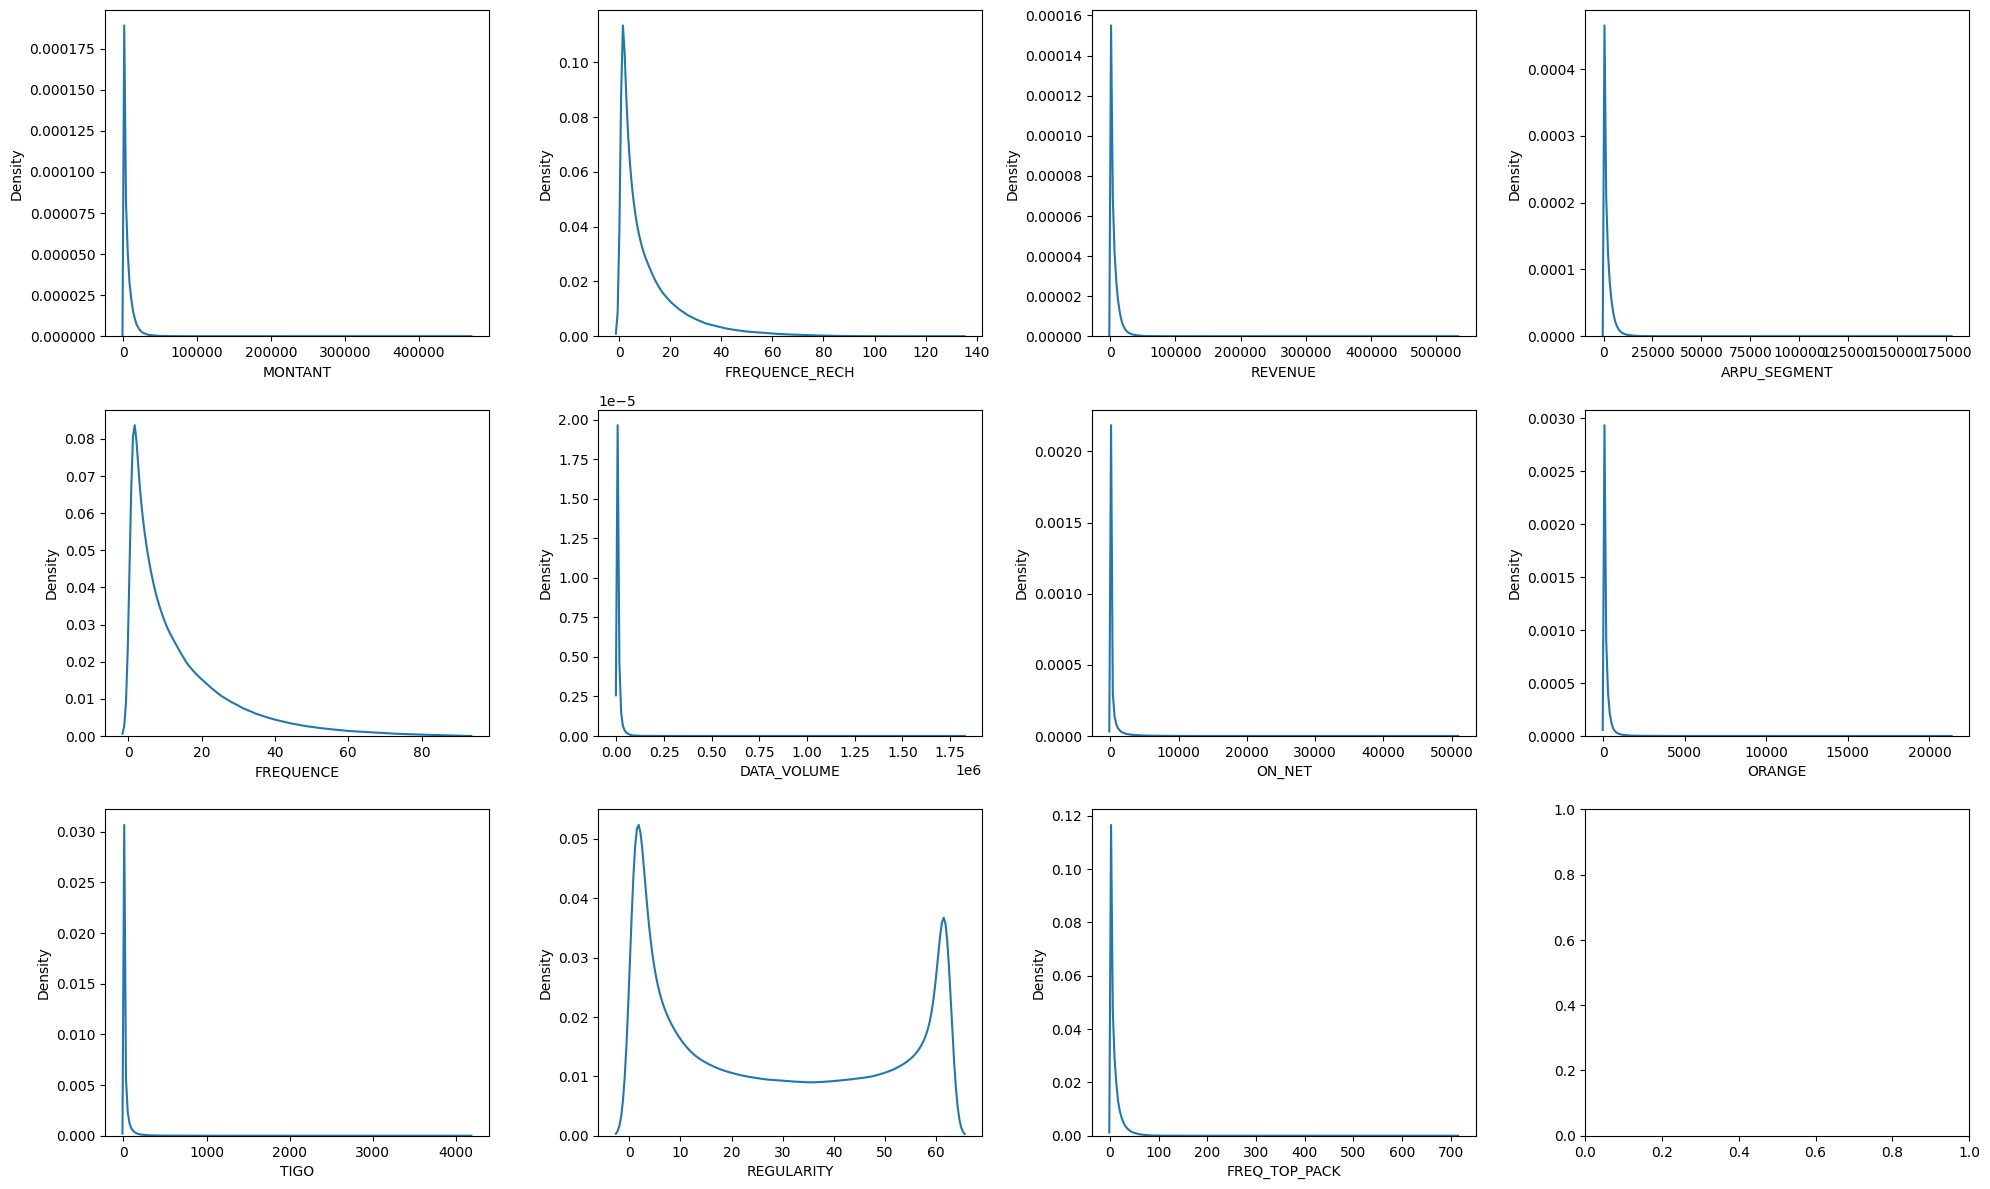

In [9]:
fig, axes = plt.subplots(3, 4, figsize=(20, 12))

sns.kdeplot(data=df, x="MONTANT", ax=axes[0, 0])
sns.kdeplot(data=df, x="FREQUENCE_RECH", ax=axes[0, 1])
sns.kdeplot(data=df, x="REVENUE", ax=axes[0, 2])
sns.kdeplot(data=df, x="ARPU_SEGMENT", ax=axes[0, 3])

sns.kdeplot(data=df, x="FREQUENCE", ax=axes[1, 0])
sns.kdeplot(data=df, x="DATA_VOLUME", ax=axes[1, 1])
sns.kdeplot(data=df, x="ON_NET", ax=axes[1, 2])
sns.kdeplot(data=df, x="ORANGE", ax=axes[1, 3])

sns.kdeplot(data=df, x="TIGO", ax=axes[2, 0])
sns.kdeplot(data=df, x="REGULARITY", ax=axes[2, 1])
sns.kdeplot(data=df, x="FREQ_TOP_PACK", ax=axes[2, 2])

plt.tight_layout()
plt.show()

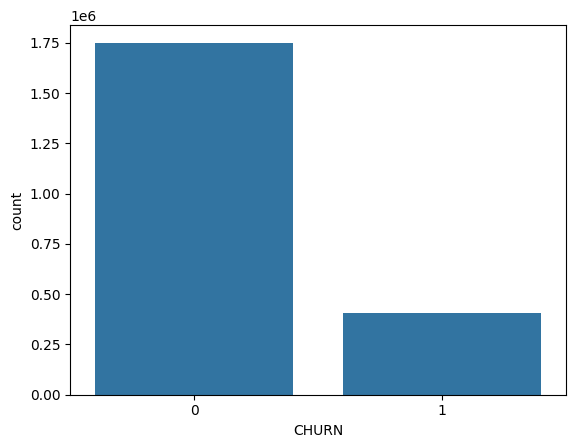

In [10]:
sns.countplot(data=df, x="CHURN")
plt.show()

## Data preprocessing

In [11]:
# Resampling

In [12]:
X = df.drop(["user_id", "MRG", "ZONE1", "ZONE2", "CHURN"], axis=1)
y = df.CHURN

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)
print(X_train.shape)
print(X_test.shape)

(2046345, 14)
(107703, 14)


In [43]:
categorical_cols = X.select_dtypes(include=['object', 'category']).columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns

preprocessor = ColumnTransformer(
    transformers=[
        # Impute missing values in categorical columns and then apply one-hot encoding
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), categorical_cols),
        # Impute missing values in numerical columns and then apply scaling
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numerical_cols)
    ], remainder='passthrough')

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

## Model Training

In [70]:
model = Sequential()

# Input layer
model.add(Dense(256, input_dim=X_train_processed.shape[1], activation='relu', kernel_initializer=HeNormal(), kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())

# Hidden layers
model.add(Dense(128, activation='relu', kernel_initializer=HeNormal(), kernel_regularizer=l2(0.001)))
model.add(Dropout(0.3))  
model.add(BatchNormalization())

model.add(Dense(64, activation='relu', kernel_initializer=HeNormal(), kernel_regularizer=l2(0.001)))
model.add(Dropout(0.3))  
model.add(BatchNormalization())

# Output layer
model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_23 (Dense)            (None, 256)               45056     
                                                                 
 batch_normalization_9 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 dense_24 (Dense)            (None, 128)               32896     
                                                                 
 dropout_16 (Dropout)        (None, 128)               0         
                                                                 
 batch_normalization_10 (Ba  (None, 128)               512       
 tchNormalization)                                               
                                                                 
 dense_25 (Dense)            (None, 64)              

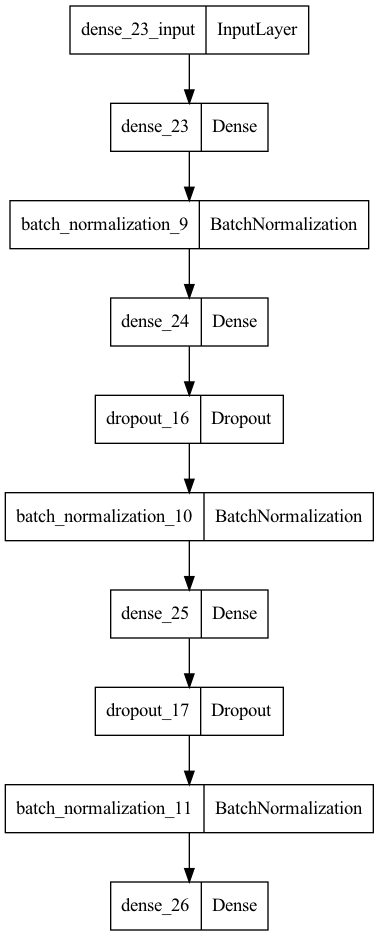

In [75]:
plot_model(model, to_file="../dnn.png")

In [71]:
#optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001, clipvalue=0.5)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [72]:
with tf.device('/cpu:0'):
    model.fit(X_train_processed, y_train, epochs=10, batch_size=64, validation_split=0.1) #validation_data=(X_test_processed, y_test))

Epoch 1/10
28777/28777 [==============================] - 53s 2ms/step - loss: 0.2898 - accuracy: 0.8726 - val_loss: 0.2653 - val_accuracy: 0.8775
Epoch 2/10
28777/28777 [==============================] - 51s 2ms/step - loss: 0.2703 - accuracy: 0.8744 - val_loss: 0.2614 - val_accuracy: 0.8775
Epoch 3/10
28777/28777 [==============================] - 51s 2ms/step - loss: 0.2687 - accuracy: 0.8753 - val_loss: 0.2622 - val_accuracy: 0.8775
Epoch 4/10
28777/28777 [==============================] - 70s 2ms/step - loss: 0.2683 - accuracy: 0.8762 - val_loss: 0.2629 - val_accuracy: 0.8768
Epoch 5/10
28777/28777 [==============================] - 118s 4ms/step - loss: 0.2700 - accuracy: 0.8751 - val_loss: 0.2633 - val_accuracy: 0.8759
Epoch 6/10
28777/28777 [==============================] - 64s 2ms/step - loss: 0.2694 - accuracy: 0.8754 - val_loss: 0.2626 - val_accuracy: 0.8758
Epoch 7/10
28777/28777 [==============================] - 85s 3ms/step - loss: 0.2693 - accuracy: 0.8755 - val_loss: 

In [73]:
model.save("../models/dnn.h5")

In [48]:
loss, accuracy = model.evaluate(X_test_processed, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

3366/3366 [==============================] - 1s 420us/step - loss: 0.2628 - accuracy: 0.8744
Test Loss: 0.2627967596054077, Test Accuracy: 0.8743767738342285


In [58]:
model_2 = Sequential()
model_2.add(LSTM(8, return_sequences=True, input_shape=(X_train_processed.shape[1], 1)))
model.add(Activation(swish))
model_2.add(Dropout(0.2))
model_2.add(LSTM(8, return_sequences=True))
model_2.add(Dropout(0.2))
model.add(Activation(swish))
model_2.add(Dense(1, activation='sigmoid'))
model_2.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 175, 8)            320       
                                                                 
 dropout_12 (Dropout)        (None, 175, 8)            0         
                                                                 
 lstm_5 (LSTM)               (None, 8)                 544       
                                                                 
 dropout_13 (Dropout)        (None, 8)                 0         
                                                                 
 dense_21 (Dense)            (None, 1)                 9         
                                                                 
Total params: 873 (3.41 KB)
Trainable params: 873 (3.41 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [59]:
model_2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])  # Adjust loss and metrics as per your task

In [60]:
model_2.fit(X_train_processed, y_train, epochs=10, batch_size=64, validation_split=0.05)

Epoch 1/10
30376/30376 [==============================] - 1142s 38ms/step - loss: 0.2975 - accuracy: 0.8620 - val_loss: 0.2645 - val_accuracy: 0.8765
Epoch 2/10
26466/30376 [=========================>....] - ETA: 4:37 - loss: 0.2644 - accuracy: 0.8771

KeyboardInterrupt: 

In [61]:
model_test = Sequential()

model_test.add(SimpleRNN(4, return_sequences=True, input_shape=(X_train_processed.shape[1], 1)))
model_test.add(Activation(swish))
model_test.add(Dropout(0.2))

model_test.add(SimpleRNN(4, return_sequences=False))
model_test.add(Activation(swish))
model_test.add(Dropout(0.2))

# Output layer for binary classification
model_test.add(Dense(1, activation='sigmoid'))
model_test.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_3 (SimpleRNN)    (None, 175, 4)            24        
                                                                 
 activation_4 (Activation)   (None, 175, 4)            0         
                                                                 
 dropout_14 (Dropout)        (None, 175, 4)            0         
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, 4)                 36        
                                                                 
 activation_5 (Activation)   (None, 4)                 0         
                                                                 
 dropout_15 (Dropout)        (None, 4)                 0         
                                                                 
 dense_22 (Dense)            (None, 1)               

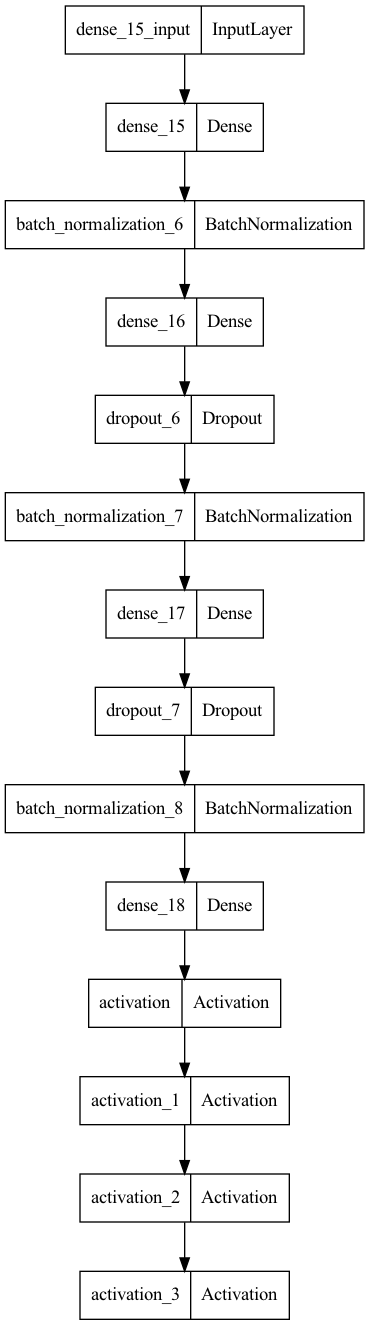

In [68]:
plot_model(model, to_file="../rnn.png")

In [63]:
model_test.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [64]:
model_test.fit(X_train_processed, y_train, epochs=10, batch_size=64, validation_split=0.05)

Epoch 1/10
30376/30376 [==============================] - 485s 16ms/step - loss: 0.3095 - accuracy: 0.8515 - val_loss: 0.2869 - val_accuracy: 0.8670
Epoch 2/10
30376/30376 [==============================] - 691s 23ms/step - loss: 0.2982 - accuracy: 0.8596 - val_loss: 0.2811 - val_accuracy: 0.8678
Epoch 3/10
30376/30376 [==============================] - 660s 22ms/step - loss: 0.2913 - accuracy: 0.8607 - val_loss: 0.2737 - val_accuracy: 0.8732
Epoch 4/10
30376/30376 [==============================] - 617s 20ms/step - loss: 0.2904 - accuracy: 0.8584 - val_loss: 0.2760 - val_accuracy: 0.8698
Epoch 5/10
30376/30376 [==============================] - 536s 18ms/step - loss: 0.2861 - accuracy: 0.8618 - val_loss: 0.2744 - val_accuracy: 0.8719
Epoch 6/10
30376/30376 [==============================] - 510s 17ms/step - loss: 0.2840 - accuracy: 0.8633 - val_loss: 0.2731 - val_accuracy: 0.8755
Epoch 7/10
30376/30376 [==============================] - 513s 17ms/step - loss: 0.2805 - accuracy: 0.8653

In [66]:
model_2.save("../models/rnn.h5")

In [67]:
loss_2, accuracy_2 = model_2.evaluate(X_test_processed, y_test)
print(f"Test Loss: {loss_2}, Test Accuracy: {accuracy_2}")

3366/3366 [==============================] - 17s 5ms/step - loss: 0.2549 - accuracy: 0.8784
Test Loss: 0.2549183964729309, Test Accuracy: 0.8783599138259888
